In [1]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
import z2_save_jaspar, z1_save_oligos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#LOAD JASPAR & OLIGO DATA
jaspar = z2_save_jaspar.load_jaspar()

In [3]:
#LOADS BIOLOGICAL MOTIFS AND SCANS ALL SUBREGIONS FOR OCCURENCES
from pyfaidx import Fasta
sequences_fa = Fasta('/Users/ben/genomes/GRCh38.primary_assembly.genome.fa')
chrseq = str(sequences_fa["chr22"])
region_bounds=[ 38699734, 39291007]
background = dict([[l,chrseq[region_bounds[0]:region_bounds[1]].count(l) / len(chrseq[region_bounds[0]:region_bounds[1]])] for l in "ATGC"])


In [4]:

oligos, oligos_by_exp_some,oligos_by_exp = z1_save_oligos.load_oligos()
oligos_by_exp = oligos_by_exp.filter(regex='^(?!exp|\\.).*')
oligos_by_exp["exp_nm"] = oligos_by_exp.index.get_level_values("exp").to_series().apply(lambda x:re.compile('(.*)_BR').search(x).groups()[0]).values
oligos_by_exp = oligos_by_exp.reset_index()

oligos_by_exp["exp_ct"] = oligos_by_exp.exp_nm.apply(lambda x:re.compile("(U2OS|DLD1|HCT116)").search(x).groups()[0])
oligos_by_exp["exp_type"] = oligos_by_exp.exp_nm.apply(lambda x:"U2OS_NFKB" if "NFKB" in x 
                                                     else ("HCT116_GEM") if "Gem" in x
                                                     else re.compile("(U2OS|DLD1|HCT116)").search(x).groups()[0]+"_WT")

oligos["mutant_start"] = oligos.mutant_start + 30
oligos_by_exp["mutant_start"] = oligos_by_exp.mutant_start + 30
oligos_by_exp["mutant_start"] = oligos_by_exp.apply(lambda x:np.nan if x.mutant_num == 0 else x.mutant_start,axis=1)
oligos["mutant_start"] = oligos.apply(lambda x:np.nan if x.mutant_num == 0 else x.mutant_start,axis=1)

ranks = oligos_by_exp.loc[lambda x:x.mutant_num == 0].groupby("exp_type").\
    apply(lambda x:x.groupby("oligo").mu.mean().sort_values(ascending=False).\
          reset_index().reset_index().set_index("oligo").\
        rename({"index":"ranksort"},axis="columns").\
        ranksort).unstack(level=0).rename(lambda x: x+"_rank",axis = "columns")
oligos_by_exp = oligos_by_exp.join(ranks, on="oligo")

obe = oligos_by_exp

#LOADS MOTIF DATA
motif_oligos_data = pd.read_csv("../out/0722_motif_oligos_data.csv")


In [5]:
motif_oligos_data =  motif_oligos_data.join(jaspar.filter(regex="threshold_.*"),on="jaspar_id")


In [6]:

motif_oligos_data["affine_score"] = motif_oligos_data.score - motif_oligos_data[["threshold_patser","threshold_fdr_005"]].T.min()

In [7]:

ranks_by_rep = oligos_by_exp.loc[lambda x:x.mutant_num == 0].groupby(["exp_type","rep"]).\
    apply(lambda x:x.groupby("oligo").mu.mean().sort_values(ascending=False).\
          reset_index().reset_index().set_index("oligo").\
        rename({"index":"ranksort"},axis="columns").\
        ranksort).unstack(level=0).rename(lambda x: x+"_rank",axis = "columns")

In [8]:
obe_w_repchanges = oligos_by_exp.join(
    (ranks_by_rep.loc[1] - ranks_by_rep.loc[2]).rename(lambda x:x+"_repchange",axis ="columns")
    ,on="oligo")




In [9]:
intervals = pd.read_csv("../out/0729_intervals.csv")

In [10]:
affine_score_threshold = 1

### IDENTIFICATION AND DESCRIPTION OF HIGHLY EXPRESSED ENHANCER CANDIDATES IN MULTIPLE CELL TYPES ###

####  Where are the promoters/enhancers (STARR-Seq peaks) as defined by this assay for this data in an overall pool? ####  
In the aggregate pooled data, on average [n_tx_mean] transcripts are identified for [n_bcs_total] barcodes (n_bcs_per_oligos. The number of transcripts can be counted per barcode, giving a number for the expression rate of the that barcode which is comparable between [SEE APPENDIX A, TRANSCRIPT COUNTING] barcoded plasmids in all of our pooled sequencing. We call this transcription rate “μ” the pooled expression of a given oligo, which can be defined on a per-experiment or pooled basis.

In [11]:
pprint({
    "n_tx_mean":oligos.n_transcripts.mean(),
    "n_bcs_total":oligos.n_bcs.sum(),
    "n_bcs_avg":oligos.n_bcs.mean(),
})

{'n_bcs_avg': 132.3329294153287,
 'n_bcs_total': 1310493,
 'n_tx_mean': 1215.4653135413512}


Considering μ over all oligo start positions, we observe ~4-5 variants of each oligo and average this quantity together to define an average expression level. Considering all such oligo-averaged expression levels, we can define peaks of expression, or putative enhancer sequences. Going forward, we define the top 5% of oligo positions by location as potential enhancer sequences “POOL-activators”. A total of [POOL_activator_len] positions of 2000 are captured by this method and defined as pooled enhancers. Likewise, the bottom 5% “POOL-repressors” of oligos by expression are split into a separate group and identified as repressors, whereas the bottom 50%of oligos are identified and described as the null background “POOL-null”.

In [12]:
wt_oligos = oligos.loc[lambda x: x.mutant_num ==0]
POOL_activators = wt_oligos.loc[lambda x: x.mu > x.mu.quantile(.95)]
POOL_repressors = wt_oligos.loc[lambda x: x.mu < x.mu.quantile(.05)]
POOL_null = wt_oligos.loc[lambda x: x.mu < x.mu.quantile(.5)]

print({
    "POOL_activator_len": len(POOL_activators),
    "POOL_repressor_len": len(POOL_repressors),
    "POOL_null_len": len(POOL_null),
})

{'POOL_activator_len': 99, 'POOL_repressor_len': 99, 'POOL_null_len': 984}


Second performing the same analysis as above, we identified a set of 5% expressed oligos, repressed oligos, and null / negative control oligos for each replicate of each experiment “{EXP_N}-activators” / “{EXP_N}-repressors”. For each experiment, we then take an intersection of the activators, repressors, and null negative control oligos observed in the two replicates of each experiment, finding that on average 67% of these oligos are observed in both replicates over all experiments. Looking at each experiment individually, the U2OS and DLD1 cell types have replicable discovery rates of 79% and 67% respectively, with U2OS cell-type having the highest replicability overall We find that activators are overall more replicable than repressors, which is as expected based upon the distribution of log scores for each. 

{'DLD1_activator_rediscovery_rate': 0.6767676767676768,
 'EXP_activator_mean_rep_rate': 0.6749162645421956,
 'EXP_activator_rep_rate': exp_nm
DLD1_WT                       0.676768
HCT116_Gemcitabine2uM         0.482051
HCT116_WT                     0.605128
U2OS_NFKB1KO_Sorted_GFPneg    0.725389
U2OS_NFKB1KO_Sorted_GFPpos    0.652850
U2OS_NFKB2KO_Sorted_GFPneg    0.708333
U2OS_NFKB2KO_Sorted_GFPpos    0.783505
U2OS_WT                       0.765306
dtype: float64,
 'EXP_activators_mean_len': 65.625,
 'EXP_null_mean_len': 657.625,
 'EXP_null_mean_rep_rate': 0.6822818738250028,
 'EXP_repressor__mean_rep_rate': 0.32968111271058587,
 'EXP_repressors_mean_len': 31.5,
 'MAX_activator_rediscovery_celltype': 'U2OS_NFKB2KO_Sorted_GFPpos',
 'U2OS_activator_rediscovery_rate': 0.7653061224489796}


Text(0.5, 1.0, 'histogram of normalized log2 expression rates by experiment')

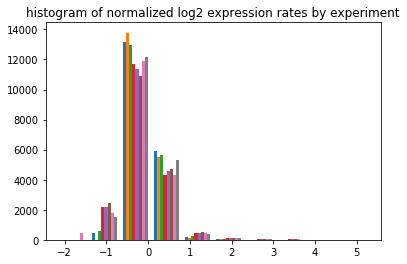

In [13]:
EXP_REP_activators = oligos_by_exp.loc[lambda x:x.mutant_num==0].groupby("exp").apply(lambda x: x.loc[x.mu > x.mu.quantile(.95)])
EXP_REP_repressors = oligos_by_exp.loc[lambda x:x.mutant_num==0].groupby("exp").apply(lambda x: x.loc[x.mu < x.mu.quantile(.05)])
EXP_REP_null = oligos_by_exp.loc[lambda x:x.mutant_num==0].groupby("exp").apply(lambda x: x.loc[x.mu < x.mu.quantile(.5)])

EXP_activator_oligos = EXP_REP_activators.groupby("exp_nm").apply(lambda g1:g1.loc[g1.oligo.isin(g1.set_index("rep").loc[1].oligo) & g1.oligo.isin(g1.set_index("rep").loc[2].oligo)])
EXP_repressor_oligos = EXP_REP_repressors.groupby("exp_nm").apply(lambda g1:g1.loc[g1.oligo.isin(g1.set_index("rep").loc[1].oligo) & g1.oligo.isin(g1.set_index("rep").loc[2].oligo)])
EXP_null_oligos = EXP_REP_null.groupby("exp_nm").apply(lambda g1:g1.loc[g1.oligo.isin(g1.set_index("rep").loc[1].oligo) & g1.oligo.isin(g1.set_index("rep").loc[2].oligo)])

EXP_activator_rep_rate =  EXP_activator_oligos.groupby(level="exp_nm").apply(lambda x:x.oligo.nunique()) / EXP_REP_activators.groupby("exp_nm").apply(lambda x:x.groupby("rep").oligo.nunique().mean())
EXP_repressor_rep_rate =  EXP_repressor_oligos.groupby(level="exp_nm").apply(lambda x:x.oligo.nunique()) / EXP_REP_repressors.groupby("exp_nm").apply(lambda x:x.groupby("rep").oligo.nunique().mean())
EXP_null_rep_rate =  EXP_null_oligos.groupby(level="exp_nm").apply(lambda x:x.oligo.nunique()) / EXP_REP_null.groupby("exp_nm").apply(lambda x:x.groupby("rep").oligo.nunique().mean())
#EXP_repressor_rep_rate =  EXP_repressor_oligos.groupby(level="exp_nm").reset_index("oligo").oligo.nunique().mean() / EXP_REP_repressors.groupby("exp_nm").reset_index("oligo").oligo.nunique()

DLD1_activator_rediscovery_rate = EXP_activator_rep_rate.loc["DLD1_WT"]
U2OS_activator_rediscovery_rate = EXP_activator_rep_rate.loc["U2OS_WT"]
MAX_activator_rediscovery_celltype = EXP_activator_rep_rate.idxmax()

pprint({
    "EXP_activators_mean_len":EXP_activator_oligos.groupby(level="exp_nm").oligo.nunique().mean(),
    "EXP_repressors_mean_len":EXP_repressor_oligos.groupby(level="exp_nm").oligo.nunique().mean(),
    "EXP_null_mean_len":EXP_null_oligos.groupby(level="exp_nm").oligo.nunique().mean(),
    "EXP_repressor__mean_rep_rate":EXP_repressor_rep_rate.mean(),
    "EXP_activator_mean_rep_rate":EXP_activator_rep_rate.mean(),
    "EXP_null_mean_rep_rate":EXP_null_rep_rate.mean(),
    "U2OS_activator_rediscovery_rate":U2OS_activator_rediscovery_rate,
    "DLD1_activator_rediscovery_rate":DLD1_activator_rediscovery_rate,
    "MAX_activator_rediscovery_celltype":MAX_activator_rediscovery_celltype,
    "EXP_activator_rep_rate": EXP_activator_rep_rate,
})


plt.gcf().set_size_inches(6,4)
ax = plt.gca()
plt.hist([(np.log2(g.mu) - np.log2(g.mu.mean())).rename(k) for k, g in oligos_by_exp.groupby("exp_nm")])

ax.set_title("histogram of normalized log2 expression rates by experiment")


Observing that APOBEC is expressed in DLD1 and U2OS cells, we defined a further set of activators defined as “APOBEC-on” enhancers, consisting of those enhancers which were identified both in the DLD1 replicates and the U2OS replicates, this set had {100} elements. Lastly, observing that APOBEC is not expressed in HCT116 cells, we defined a final set of activators of interest, consisting of {59} possible transcription activators which exhibited high transcription in U2OS and DLD1 cells (ie, in the APOBEC-on enhancers), but not in HCT116 cells. These were called “APOBEC-exclusive” candidate enhancer regions. Observing that U2OS expression tended to differ greatly with DLD1 expression, and U2OS expression was overall higher, we also investigated another set, "U2OS-on", with U2OS-identified enhancers, excluding those which were detected in HCT116 peaks.


In [14]:

APOBEC_on_oligo_ids = set(EXP_activator_oligos.loc["DLD1_WT"].oligo).intersection(EXP_activator_oligos.loc["U2OS_WT"].oligo)
APOBEC_sometimes_oligo_ids = set(EXP_activator_oligos.loc["DLD1_WT"].oligo).union(EXP_activator_oligos.loc["U2OS_WT"].oligo)
ABon_ids = APOBEC_on_oligo_ids
ABst_ids = APOBEC_sometimes_oligo_ids


APOBEC_exclusive_oligo_ids =APOBEC_on_oligo_ids.difference(EXP_activator_oligos.loc["HCT116_WT"].oligo)
U2OS_on_oligo_ids = set(EXP_activator_oligos.loc["U2OS_WT"].oligo)


ABex_ids = APOBEC_exclusive_oligo_ids 
U2on_ids = U2OS_on_oligo_ids
U2ex_ids = set(U2OS_on_oligo_ids).difference(EXP_activator_oligos.loc["HCT116_WT"].oligo)

ALLen_ids = set(EXP_activator_oligos.oligo)
WTst_ids =APOBEC_sometimes_oligo_ids.union(EXP_activator_oligos.loc["HCT116_WT"].oligo)


AB_differential_enhancer_ids = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        loc[lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank) > 100].oligo.unique()

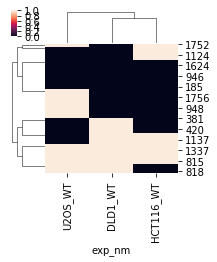

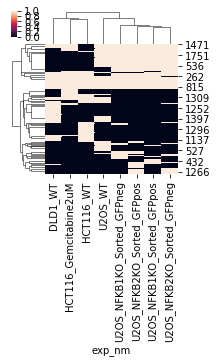

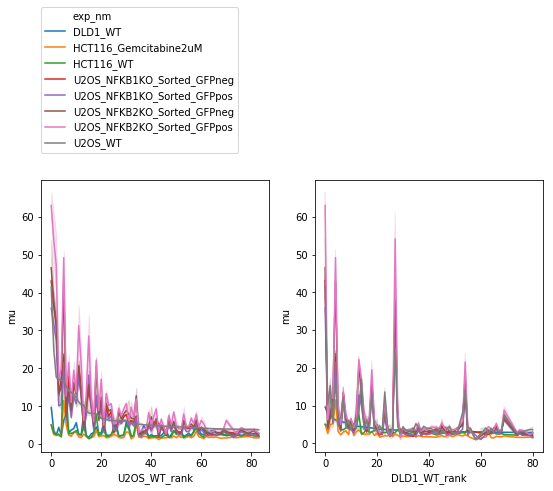

In [15]:

oligo_exp_activator_matrix = pd.Series(1, index =EXP_activator_oligos.oligo.to_frame().reset_index().set_index(["exp_nm","oligo"]).index).loc[lambda df: ~df.index.duplicated(keep='first') ].unstack("exp_nm").fillna(0)
oligo_exp_activator_matrix = oligo_exp_activator_matrix.append( [ pd.Series(0, index = oligo_exp_activator_matrix.columns).rename(o) for o in [e for e in obe.oligo.unique() if e not in oligo_exp_activator_matrix.index] ])
correlations = oligo_exp_activator_matrix.corr()
for nm in correlations.columns: correlations.loc[nm,nm] = 0

intersection_grid = np.array([[np.sum(oligo_exp_activator_matrix[c1].values * oligo_exp_activator_matrix[c2].values)
     for c1 in oligo_exp_activator_matrix.columns ]
     for c2 in oligo_exp_activator_matrix.columns])

sns.clustermap((oligo_exp_activator_matrix.loc[oligo_exp_activator_matrix.sum(axis=1) >0].filter(regex=".*WT.*" )),figsize=(3,3))
#sns.clustermap(oligo_exp_activator_matrix.filter(regex=".*WT.*" ).T.filter(regex=".*WT.*" ),figsize=(3,3))
sns.clustermap((oligo_exp_activator_matrix.loc[oligo_exp_activator_matrix.sum(axis=1) >0]),figsize=(3,3))

f,subs = plt.subplots(1,2)
f.set_size_inches(9,5)

plt.sca(subs[0])
sns.lineplot(x = "U2OS_WT_rank", y = "mu",  hue = "exp_nm", data = oligos_by_exp.loc[lambda x: x.oligo.isin(EXP_activator_oligos.loc["U2OS_WT"].oligo)])
plt.legend(loc=[0,1.1])

plt.sca(subs[1])
sns.lineplot(x = "DLD1_WT_rank", y = "mu",  hue = "exp_nm", data = oligos_by_exp.loc[lambda x: x.oligo.isin(EXP_activator_oligos.loc["DLD1_WT"].oligo)],legend=False)


#### Do enhancer regions exhibit differential activity in the cell types under study? ####
We had previously identified separate groups of top5% enhancers in each cell type under study. Furthermore, we observed that the groups of top5% enhancers were different for each of the cell types. To define APOBEC-on activators, we took an intersection of the top5% enhancers. To study differential expression in these cell types, we defined a new set of APOBEC-sometimes enhancer regions consisting of the union of top5% enhancer oligos in each of these (ABst) experiments. 



There were {100} total enhancer locations in the ABst set. For each enhancer, we examined the descending rank-sorted order of that enhancer in the experimental data for that locus, assigning a number equal to the absolute value of that rank sort-order difference in each set to each of the APOBEC-somstetimes enhancer regions. Looking at the full set of APOBEC-sometimes enhancer regions, we found a mean ranksort discrepancy of {248} between the two data sets. To quantify significance of this number, we also computed the mean ranksort discrepancy of the APOBEC-sometimes enhancers in each of the two experimental replicates of DLD1 and U2OS. We found that the average absolute ranksort differential of APOBEC-sometimes enhancer candidates was [111] and [49] in the DLD1 and U2OS replicates respectively, with an overall mean of [250]. Importantly, we found that amongst the U2OSon and DLD1on oligos, the average rank changes between replicates was 7.63 and 12.75 respectively, leading us to conclude that for the most expressed oligos, the expression rank change provided an internally consistent number.

Equipped with this measure, we set a threshold of rank expression change of 100 ranks and observed that 47 of the ABst potential enahncers changed in rank by 100 or more between the two experiments. We called these “APOBEC-differential-enhancers”, and noted that these 47 oligos were candidates for cell-type specific differential activation of APOBEC.


In [16]:
abst_U2OSNKFB_U2OS_WT_rankdiff = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.U2OS_NFKB_rank),axis=1)

all_U2OSNKFB_U2OS_WT_rankdiff = obe.loc[lambda x:  x.mutant_num == 0].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.U2OS_NFKB_rank),axis=1)

abst_dld1_U2OS_WT_rankdiff = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank),axis=1)

all_dld1_U2OS_WT_rankdiff = obe.loc[lambda x: x.mutant_num == 0].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank),axis=1)

AB_differential_enhancer_ids = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        loc[lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank) > 100].oligo.unique()

print(f""" mean difference between rank sorts in U2OS vs DLD1 cells over--
   ABST oligos: ({abst_dld1_U2OS_WT_rankdiff.mean():.2f})  
   ALL wt oligos: ({all_dld1_U2OS_WT_rankdiff.mean():.2f})

Looking at only U2OS cell lines in NFKB-ko and NFKB designs, we find that the differences are reduced
   ABST oligos: ({abst_U2OSNKFB_U2OS_WT_rankdiff.mean():.2f})  
   ALL oligos: ({all_U2OSNKFB_U2OS_WT_rankdiff.mean():.2f})  


... and furthermore, that the rank change difference of expression levels amongst ABst expressed oligos is
reduced compared to the rank change difference between all oligos. In order to quantify the base level of
noise in rank fold change amongst all oligos, we looked at the average fold change difference between replicates,
finding that the overall change in expression ranks for 

ALL OLIGOS (U2OS) {obe_w_repchanges["U2OS_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (U2OS) {obe_w_repchanges.loc[lambda x: x.oligo.isin(ABst_ids)]["U2OS_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (U2OS) {obe_w_repchanges.loc[lambda x: x.oligo.isin(U2on_ids)]["U2OS_WT_rank_repchange"].abs().mean():.2f}


ALL OLIGOS (DLD1) {obe_w_repchanges["DLD1_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (DLD1) {obe_w_repchanges.loc[lambda x: x.oligo.isin(ABst_ids)]["DLD1_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (DLD1) {obe_w_repchanges.loc[lambda x: x.oligo.isin(EXP_activator_oligos.loc["DLD1_WT"].oligo)]["DLD1_WT_rank_repchange"].abs().mean():.2f}

Number of "APOBEC-differentialy-expressed" oligos:
    {len(AB_differential_enhancer_ids)} 

""")






 mean difference between rank sorts in U2OS vs DLD1 cells over--
   ABST oligos: (273.82)  
   ALL wt oligos: (324.79)

Looking at only U2OS cell lines in NFKB-ko and NFKB designs, we find that the differences are reduced
   ABST oligos: (111.69)  
   ALL oligos: (274.94)  


... and furthermore, that the rank change difference of expression levels amongst ABst expressed oligos is
reduced compared to the rank change difference between all oligos. In order to quantify the base level of
noise in rank fold change amongst all oligos, we looked at the average fold change difference between replicates,
finding that the overall change in expression ranks for 

ALL OLIGOS (U2OS) 265.13
ABST OLIGOS (U2OS) 81.38
ABST OLIGOS (U2OS) 8.24


ALL OLIGOS (DLD1) 295.02
ABST OLIGOS (DLD1) 111.68
ABST OLIGOS (DLD1) 12.57

Number of "APOBEC-differentialy-expressed" oligos:
    54 




Starting from this measure of differential expression in wild-type cells that were highly expressive of APOBEC, we sought to apply the same measure to quantification of differential expression between the APOBEC-expressing cell lines and the HCT116 cell type which does not natively express APOBEC. Defining an inclusive set of enhancers, WILDTYPE-activators with [XXX] members, consisting of the top5% enhancers from DLD1, HCT116, and U2OS, we looked at differential expression, computed between all 3x3 cell types for each of these enhancers. We were also curious to see how differential expression of the bot5% would vary between these three cell types and therefore defined the set WILDTYPE-repressors and computed the same score, using all 3x3 comparisons.

Using the same definitions above, we computed average and std deviation of ranksort discrepancies for activators ( [XXX]mean, [XXX]stddev ) and repressors  ( [XXX]mean, [XXX]stddev )  individually and identified as differentially expressed all those oligos which crossed the threshold of mean + 1 std discrepancy change. By this measure, we found that [XXX] / ([XXX]) oligos were differentially expressed between either DLD1 / (U2OS) and HCT116 cells respectively. We called their intersection, the “APOBEC-on-enhancers” (XXX regions). Comparing the set of oligos previously identified as in the DLD1 and U2OS sets but not in HCT116 cells (“ABOPEC-exclusive” oligos), we found that [XXX]% of APOBEC-exclusive oligos were found in this set of differentially expressed oligos, confirming the internal consistency of these two measures. 

In [17]:

obe_wtst = obe.loc[lambda x: x.oligo.isin(WTst_ids) ]
celltypes = pd.Series(["DLD1_WT","U2OS_WT","HCT116_WT"], index = ["DLD1_WT","U2OS_WT","HCT116_WT"])
exptypes = pd.Series(obe.exp_type.unique(), index = obe.exp_type.unique())

enhancer_intersection_sizes = celltypes.apply(lambda x: celltypes.apply(lambda y:len(
    set(EXP_activator_oligos.loc[x].oligo.unique()).intersection(
    set(EXP_activator_oligos.loc[y].oligo.unique())))))

WTst_differential_expression_count = \
exptypes.apply(lambda ct1: 
        exptypes.apply(lambda ct2:
            len(set(obe_wtst.loc[lambda x:(abs(x[ct1 + "_rank"]  - x[ct2+"_rank"])) > 100].oligo.unique()))))





print(f"""
number of oligos highly expressed in at least one of: DLD1, U2OS, HCT116 WILDTYPE CELLS: {len(WTst_ids)}

Looking at the number of differentially expressed transcripts by delta-rank > 100 metric in each cell type, we
get:
   U2OS --> DLD1 {WTst_differential_expression_count.loc["U2OS_WT","DLD1_WT"]}
   U2OS --> HTC116 {WTst_differential_expression_count.loc["U2OS_WT","HCT116_WT"]}
   DLD1 --> HCT116 {WTst_differential_expression_count.loc["DLD1_WT","HCT116_WT"]}
   
Counts of differentially expressed transcripts in each cell type.

Looking at experiment type changes, we find 
   U2OS_WT --> U2OS_NFKB_KO {WTst_differential_expression_count.loc["U2OS_WT","U2OS_NFKB"]}
   HCT116_WT --> HCT116_GEM {WTst_differential_expression_count.loc["HCT116_WT","HCT116_GEM"]}
      """)



number of oligos highly expressed in at least one of: DLD1, U2OS, HCT116 WILDTYPE CELLS: 124

Looking at the number of differentially expressed transcripts by delta-rank > 100 metric in each cell type, we
get:
   U2OS --> DLD1 63
   U2OS --> HTC116 62
   DLD1 --> HCT116 45
   
Counts of differentially expressed transcripts in each cell type.

Looking at experiment type changes, we find 
   U2OS_WT --> U2OS_NFKB_KO 38
   HCT116_WT --> HCT116_GEM 49
      


### Do enhancer regions exhibit differential activity in the cell types under study? ###
We had previously identified separate groups of top5% enhancers in each cell type under study. Furthermore, we observed that the groups of top5% enhancers were different for each of the cell types. To define APOBEC-on activators, we took an intersection of the top5% enhancers. To study differential expression in these cell types, we defined a new set of APOBEC-sometimes enhancer regions consisting of the union of top5% enhancer oligos in each of these experiments. 

There were [XXX] total enhancer locations in this set. For each enhancer, we examined the descending rank-sorted order of that enhancer in the experimental data for that locus, assigning a number equal to the absolute value of that rank sort-order difference in each set to each of the APOBEC-somstetimes enhancer regions. Looking at the full set of APOBEC-sometimes enhancer regions, we found a mean ranksort discrepancy of [XXX] between the two data sets. To quantify significance of this number, we also computed the mean ranksort discrepancy of the APOBEC-sometimes enhancers in each of the two experimental replicates of DLD1 and U2OS. We found that the average absolute ranksort differential of APOBEC-sometimes enhancer candidates was [XXX] and [XXX] in the DLD1 and U2OS replicates respectively, with an overall mean of [XXX] and overall standard deviation of [XXX]. We set a threshold of [XXX], which was the mean discrepancy + 1 STD as the ranksort discrepancy to define a given enhancer oligo as differentially activating between the two cell types and found that amongst the [XXX] oligos in APOBEC-sometimes, [XXX] ([XXX]%) “APOBEC-differential-activators”, were differentially expressed by this measure.

Starting from this measure of differential expression in wild-type cells that were highly expressive of APOBEC, we sought to apply the same measure to quantification of differential expression between the APOBEC-expressing cell lines and the HCT116 cell type which does not natively express APOBEC. Defining an inclusive set of enhancers, WILDTYPE-activators with [XXX] members, consisting of the top5% enhancers from DLD1, HCT116, and U2OS, we looked at differential expression, computed between all 3x3 cell types for each of these enhancers. We were also curious to see how differential expression of the bot5% would vary between these three cell types and therefore defined the set WILDTYPE-repressors and computed the same score, using all 3x3 comparisons.

Using the same definitions above, we computed average and std deviation of ranksort discrepancies for activators ( [XXX]mean, [XXX]stddev ) and repressors  ( [XXX]mean, [XXX]stddev )  individually and identified as differentially expressed all those oligos which crossed the threshold of mean + 1 std discrepancy change. By this measure, we found that [XXX] / ([XXX]) oligos were differentially expressed between either DLD1 / (U2OS) and HCT116 cells respectively. We called their intersection, the “APOBEC-on-enhancers” (XXX regions). Comparing the set of oligos previously identified as in the DLD1 and U2OS sets but not in HCT116 cells (“ABOPEC-exclusive” oligos), we found that [XXX]% of APOBEC-exclusive oligos were found in this set of differentially expressed oligos, confirming the internal consistency of these two measures. 




In [18]:
diffex = exptypes.apply(lambda ct1: 
        exptypes.apply(lambda ct2:
            obe_wtst.loc[lambda x:(x[ct1 + "_rank"]  - x[ct2+"_rank"]) > 100].oligo.unique())).stack()\
    .groupby(level=[0,1]).apply(lambda x:pd.Series([e for i,e in enumerate(x.values[0])]))

diffex = diffex.rename("oligo").reset_index(level=2,drop=True)
diffex = diffex.rename_axis(["expressed","unexpressed"]).reset_index()


# ZERO AREA FILTERING #

In [19]:
all_obe = oligos_by_exp.reset_index().loc[lambda x:x.mutant_num<5].groupby(["starts","mutant_num","exp_type"]).mu.mean()

In [20]:
from scipy.stats import ks_2samp

In [21]:
filters = pd.concat(
    [all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([(df.values[ofs:ofs+4,:] * (
        np.concatenate([
            (np.zeros((4,1))+1),
            np.fliplr(1 - np.diag([1,1,1,1]))],
        axis=1))
               ).sum()  
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("allothers") / 16,
     all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([(df.values[ofs:ofs+4,:] * (
        np.concatenate([
            (np.zeros((4,1))),
            np.fliplr( np.diag([1,1,1,1]))],
        axis=1))
               ).sum()  
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("onlyablations") / 4,
     
     all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([
        (df.values[ofs:ofs+5,:][np.nonzero(
                       1-np.array(
                          [[0,0,0,0,1],
                           [0,0,0,1,1],
                           [0,0,1,1,0],
                           [0,1,1,0,0],
                           [0,1,0,0,0]]))]
               ).sum()   
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("allothers2") / 17,
     all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([np.std(df.values[ofs:ofs+4,:][np.nonzero (
        np.concatenate([
            (np.zeros((4,1))+1),
            np.fliplr(1 - np.diag([1,1,1,1]))],
        axis=1))
                                             ])
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("allothersstd"),
     all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([np.std(df.values[ofs:ofs+4,:])  
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("std"),
         all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([
        (df.values[ofs:ofs+5,:][np.nonzero(
                       np.array([[0,0,0,0,1],
                       [0,0,0,1,1],
                       [0,0,1,1,0],
                       [0,1,1,0,0],
                       [0,1,0,0,0]]))]
               ).sum()  
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("onlyablations2") / 8,
          all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([(df.values[ofs:ofs+4,:] * (
        np.concatenate([
            (np.zeros((4,1))),
            np.fliplr(1 - np.diag([1,1,1,1]))],
        axis=1))
               ).sum()  
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("othermutants") / 12,
     
          all_obe.unstack(level=1).groupby(level=1).apply(
    lambda df:
    pd.Series([(df.values[ofs:ofs+4,:] * (
        np.concatenate([
            (np.zeros((4,1))+1),
            np.fliplr(0* np.diag([1,1,1,1]))],
        axis=1))
               ).sum()  
        for ofs in range(len(df.values) - 4)],index = df.index[4:])
).rename("onlywildtype") / 4,
     all_obe.unstack(level=1).groupby(level=1).apply(lambda df:
                                                
       pd.Series([ks_2samp( df.values[ofs:ofs+4,:][np.nonzero(   np.concatenate([
            (np.zeros((4,1))+1),
            np.fliplr(1-np.diag([1,1,1,1]))],
        axis=1))] ,
                 df.values[ofs:ofs+4,:][np.nonzero(  np.concatenate([
            (np.zeros((4,1))+0),
            np.fliplr(np.diag([1,1,1,1]))],
        axis=1))])[1]
          for ofs in range(len(df.values) - 4)],index = df.index[4:])).rename("ks_pval"),
     
          all_obe.unstack(level=1).groupby(level=1).apply(lambda df:
                                                
       pd.Series([ks_2samp( df.values[ofs:ofs+5,:][np.nonzero(
                       np.array([[0,0,0,0,1],
                       [0,0,0,1,1],
                       [0,0,1,1,0],
                       [0,1,1,0,0],
                       [0,1,0,0,0]]))],
           df.values[ofs:ofs+5,:][np.nonzero(
                       1- np.array([[0,0,0,0,1],
                       [0,0,0,1,1],
                       [0,0,1,1,0],
                       [0,1,1,0,0],
                       [0,1,0,0,0]]))]
       )[1]
          for ofs in range(len(df.values) - 4)],index = df.index[4:])).rename("ks2_pval"),
     
     
     all_obe.unstack(level=1).groupby(level=1).apply(lambda df:
                                                
       pd.Series([ks_2samp( df.values[ofs:ofs+4,:][np.nonzero(   np.concatenate([
            (np.zeros((4,1))+1),
            np.fliplr(1-np.diag([1,1,1,1]))],
        axis=1))] ,
                 df.values[ofs:ofs+4,:][np.nonzero(  np.concatenate([
            (np.zeros((4,1))+0),
            np.fliplr(np.diag([1,1,1,1]))],
        axis=1))])[0]
          for ofs in range(len(df.values) - 4)],index = df.index[4:])).rename("ks_stat")
    ],axis = 1).reset_index(level=2, drop=True)

In [22]:
filters.index.names = ["exp_type","starts"]
filters["actual_starts"] = filters.index.get_level_values("starts") + 30
filters = filters.reset_index(level=1, drop = True).set_index("actual_starts",append=True)
filters.index.names = ["exp_type","mutant_start_position"]

In [23]:
filters["mutdiff"] = filters["othermutants"] - filters["onlyablations"]
filters["wtdiff"] = filters["onlywildtype"] - filters["onlyablations"]\

filters["othersdiff"] = filters["allothers"] - filters["onlyablations"]
filters["rank_mutdiff"] = filters[["mutdiff"]].join(
        filters[["mutdiff"]].groupby("mutant_start_position").mean().reset_index().sort_values("mutdiff",ascending = False).reset_index().rename_axis("rank",axis="index").reset_index().set_index(["mutant_start_position"])["rank"],
    on="mutant_start_position")["rank"]
filters["rank_ao"] = filters[["othersdiff"]].join(
        filters[["othersdiff"]].groupby("mutant_start_position").mean().reset_index().sort_values("othersdiff",ascending = False).reset_index().rename_axis("rank",axis="index").reset_index().set_index(["mutant_start_position"])["rank"],
    on="mutant_start_position")["rank"]
filters["rank_ao_dld1"] = filters[["othersdiff"]].loc[lambda x: x.index.get_level_values(0).str.contains("DLD")].join(
        filters[["othersdiff"]].groupby("mutant_start_position").mean().reset_index().sort_values("othersdiff",ascending = False).reset_index().rename_axis("rank",axis="index").reset_index().set_index(["mutant_start_position"])["rank"],
    on="mutant_start_position")["rank"]
filters["rank_ao_u2os"] = filters[["othersdiff"]].loc[lambda x: x.index.get_level_values(0).str.contains("U2OS")].join(
        filters[["othersdiff"]].groupby("mutant_start_position").mean().reset_index().sort_values("othersdiff",ascending = False).reset_index().rename_axis("rank",axis="index").reset_index().set_index(["mutant_start_position"])["rank"],
    on="mutant_start_position")["rank"]
filters["rank_ao_hct116"] = filters[["othersdiff"]].loc[lambda x: x.index.get_level_values(0).str.contains("HCT")].join(
        filters[["othersdiff"]].groupby("mutant_start_position").mean().reset_index().sort_values("othersdiff",ascending = False).reset_index().rename_axis("rank",axis="index").reset_index().set_index(["mutant_start_position"])["rank"],
    on="mutant_start_position")["rank"]


filters["filterchange"] = np.max(
    [(filters.onlyablations - filters.allothers),
     (filters.onlyablations2 - filters.allothers2)]
)
filters["ks_1or2"] = filters.apply(lambda x: (x.ks_pval < .05) | (x.ks2_pval < .05),axis =1)
filters["log_ks_pval"] = np.log(filters.ks_pval)
filters_hq = filters.loc[lambda x: x.ks_1or2]

In [24]:
filters.reset_index(level=0).loc[300]

,exp_type,allothers,onlyablations,allothers2,allothersstd,std,onlyablations2,othermutants,onlywildtype,ks_pval,...,wtdiff,othersdiff,rank_mutdiff,rank_ao,rank_ao_dld1,rank_ao_u2os,rank_ao_hct116,filterchange,ks_1or2,log_ks_pval
mutant_start_position,,,,,,,,,,,,,,,,,,,,,
300,DLD1_WT,3.580733,2.387749,3.584413,1.179587,1.167862,2.900763,3.438639,4.007014,0.025365,...,1.619265,1.192984,15,15,15.0,NaN,NaN,NaN,True,-3.674402
300,HCT116_GEM,2.209471,1.383820,2.224007,0.494753,0.562940,1.778512,2.105922,2.520117,0.005239,...,1.136297,0.825651,15,15,NaN,NaN,15.0,NaN,True,-5.251570
300,HCT116_WT,2.888226,1.543479,2.993138,0.898923,0.976372,2.329803,2.840355,3.031837,0.011883,...,1.488358,1.344747,15,15,NaN,NaN,15.0,NaN,True,-4.432655
300,U2OS_NFKB,5.903510,1.972656,5.701738,4.086069,3.981152,3.723915,6.182819,5.065584,0.002174,...,3.092927,3.930854,15,15,NaN,15.0,NaN,NaN,True,-6.131146
300,U2OS_WT,3.882751,2.066071,3.941505,2.165568,2.087932,2.660917,3.958378,3.655868,0.050954,...,1.589796,1.816679,15,15,NaN,15.0,NaN,NaN,False,-2.976822


### WHICH 30BP REGIONS PASS THE ZERO AREA FILTER & HAVE WT EXPRESSION LEVELS FALLING INTO THE TOP 5%? ###

In [25]:
qvals = [.75,.8,.85,.9,.95,.98]

In [26]:
quantiles = pd.DataFrame()
quantile_counts = pd.DataFrame()

for quantile in qvals:
    these_filters = filters_hq.copy()
    
    wt_quantile = quantile
    ablation_quantile = quantile
    change_quantile = quantile

    #USES ALL EXPRESSION VALUES
    mubar_wt_cutoffs = filters.groupby("exp_type").onlywildtype.quantile(wt_quantile)
    mubar_ablation_cutoffs = filters.groupby("exp_type").onlyablations.quantile(ablation_quantile)

    these_filters["filterchange"] =  these_filters.apply(lambda x:
                                                       np.max(np.abs([x.onlyablations - x.allothers,
                                                               x.onlyablations2 - x.allothers2,])),axis=1)
    filter_change_cutoff = these_filters.filterchange.groupby("exp_type").quantile(change_quantile)

    print(f"""wt_cutoff quantile /   change_cutoff mean quantile  {quantile} == {mubar_wt_cutoffs.mean()} {quantile} == {filter_change_cutoff.mean()}""")


    these_filters["ablation_mu_filtered"] = these_filters.apply(
        lambda y:(1 if 
                  (y.onlyablations > mubar_ablation_cutoffs.loc[y.name[0]]) &
                    (y.onlyablations > y.onlywildtype) else 0),axis=1)
    
    these_filters["wt_filtered"] = these_filters.apply(lambda y:(1 if
                 (y.onlywildtype > mubar_wt_cutoffs.loc[y.name[0]]) &
                    (y.onlywildtype > y.onlyablations) else 0),axis=1)
                                                                 
                                                                 
    these_filters["change_filtered"] = these_filters.apply(lambda y:(1 if (y.filterchange > filter_change_cutoff.loc[y.name[0]]) else 0),axis=1)
    these_filters["both_filtered"] = these_filters.wt_filtered * these_filters.change_filtered
    these_filters["both_ablation_filtered"] = these_filters.ablation_mu_filtered * these_filters.change_filtered

    these_filters["filter_color"] = these_filters.apply(
        lambda x:(6 if (x.both_filtered  and x.both_ablation_filtered)
                   else(5 if x.both_ablation_filtered
                        else(4 if x.ablation_mu_filtered
                             else(3 if x.both_filtered
                                   else(2 if x.change_filtered 
                                        else (1 if x.wt_filtered 
                                              else 0) ))))),axis=1)

    quantiles = quantiles.append(these_filters.assign(quantile = quantile))
    out = pd.Series([1,2,3]).apply(lambda n:(these_filters["filter_color"].loc[lambda x:x>0].unstack(level=0).fillna(0) == n).sum()).assign(quantile = quantile)
    quantile_counts =quantile_counts.append(out)


wt_cutoff quantile /   change_cutoff mean quantile  0.75 == 2.212794751112713 0.75 == 0.4924606953155498
wt_cutoff quantile /   change_cutoff mean quantile  0.8 == 2.2657162360341223 0.8 == 0.5652924621095266
wt_cutoff quantile /   change_cutoff mean quantile  0.85 == 2.3333730253370937 0.85 == 0.6906474215031121
wt_cutoff quantile /   change_cutoff mean quantile  0.9 == 2.452613512709276 0.9 == 1.0893545655720107
wt_cutoff quantile /   change_cutoff mean quantile  0.95 == 2.8290196863869506 0.95 == 1.9204469890617275
wt_cutoff quantile /   change_cutoff mean quantile  0.98 == 3.573078770136837 0.98 == 4.867634411963398


In [27]:
sns.set_palette("husl")

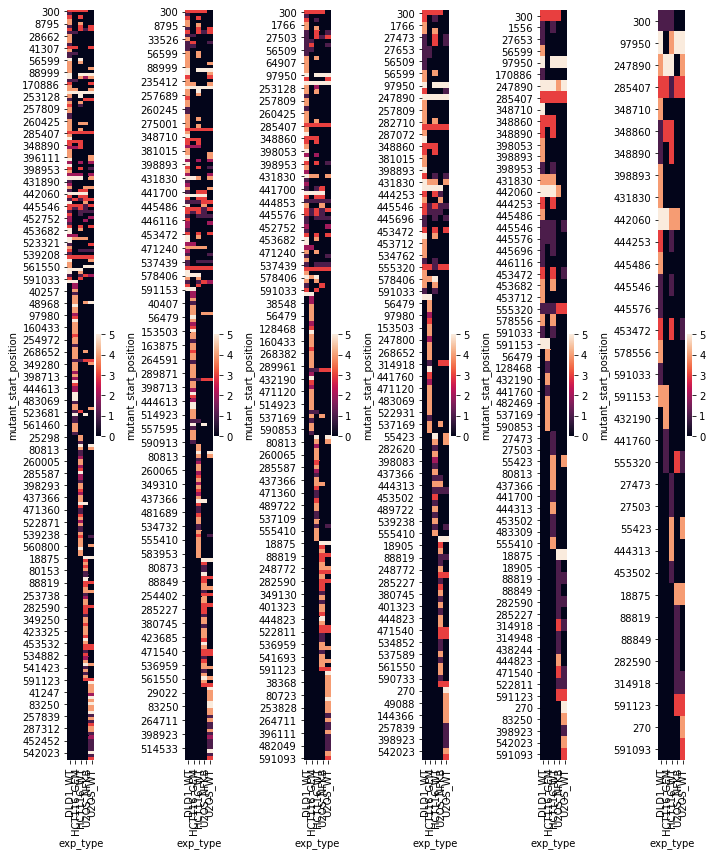

In [28]:
f,subs = plt.subplots(1,quantiles["quantile"].nunique())


f.set_size_inches(10,12)
for i,q in enumerate(sorted(quantiles["quantile"].unique())):
    plt.sca(subs[i])
    data = quantiles.loc[lambda df:df["quantile"]==q]
    sns.heatmap( data = (data["filter_color"]*(data["ks_pval"]<.1)).loc[lambda x:x>0].unstack(level=0).fillna(0))

    #plt.sca(subs[i*2+1])
    #sns.heatmap(data["log_ks_pval"].loc[lambda x:x<-2].unstack(level=0).fillna(0))

plt.tight_layout()

### Which motifs are found in motif activator / repressor candidates? ###
In the above section, we identified the 30 base pair mutations which had a statistically significant differential expression compared to the combined set of overlapping wild type and mutant oligos. Now, we are interested in joining this data with the motif hit information computed above to identify candidate motifs influencing expression levels. Note that the p values for mutants above treat activation and repression equivalently, therefore this step will identify both candidate activators and candidate repressors


In [29]:
# compute candidate mutation start positions for each motif
# note that right now if a motif has multiple possible start positions, this will
# only look at the first

mutant_positions_idx = pd.Index(oligos.mutant_start.unique()).sort_values()
motif_position_idxs = motif_oligos_data.position.apply(lambda x:mutant_positions_idx.searchsorted(x)-1)
motif_positions = motif_position_idxs.apply(lambda x: mutant_positions_idx[x])
motif_oligos_data["target_mutant_start_position"] = motif_positions

# join the motif hits with mutation data, accepting only hits which fall above a given affine score
# later in the process, we will model affine scores using a statistical model

affine_scores = [0,1,2,3,5]
qjoin_afs = pd.concat([
 pd.merge(
    quantiles.reset_index(),
    motif_oligos_data.dropna(subset =["target_mutant_start_position"]).loc[lambda x: x.affine_score > afs],
    right_on="target_mutant_start_position",
    left_on="mutant_start_position").assign(affine_score_threshold = afs)
    
    for afs in affine_scores],axis=0)
                                                                                     

In [30]:
qjoin_afs.columns

Index(['exp_type', 'mutant_start_position', 'allothers', 'onlyablations',
       'allothers2', 'allothersstd', 'std', 'onlyablations2', 'othermutants',
       'onlywildtype', 'ks_pval', 'ks2_pval', 'ks_stat', 'mutdiff', 'wtdiff',
       'othersdiff', 'rank_mutdiff', 'rank_ao', 'rank_ao_dld1', 'rank_ao_u2os',
       'rank_ao_hct116', 'filterchange', 'ks_1or2', 'log_ks_pval',
       'ablation_mu_filtered', 'wt_filtered', 'change_filtered',
       'both_filtered', 'both_ablation_filtered', 'filter_color', 'quantile',
       'motif_oligo_idx', 'hit_type', 'oligo', 'motif_hit_idx',
       'is_overlapping_wt', 'is_ablation_mut', 'is_benign_mut', 'jaspar_id',
       'position', 'score', 'mu', 'seq_actual', 'threshold_fdr_005',
       'threshold_fdr_05', 'threshold_balanced', 'threshold_patser',
       'threshold_bal', 'affine_score', 'target_mutant_start_position',
       'affine_score_threshold'],
      dtype='object')

### Which motifs instances falling in 30 BP enhancer candidates are significant above each threshold value? ###
Using the definitions of affine motif log odds scores for the instances identified above, compute the total number of motif hits which are identified overall at that significance range. These numbers will be used in the next step to evaluate the overall enrichment fractions of those instances which are identified in mutants of interest.

In [32]:
# focusing on the subset of motif instances with a basal affine score of zero, compute the total number of
# hits which fall in mutation regions found in the above step

motif_hits_of_interest = motif_oligos_data.loc[lambda x: x.affine_score > 0]
motif_filter_color_counts = pd.DataFrame()

for q in quantiles["quantile"].unique():
    qsel = qjoin_afs.loc[lambda x: x["quantile"] == q] 
    temp = qsel.groupby(['jaspar_id','exp_type',"affine_score_threshold"]).filter_color.value_counts().rename("fc_count")
    affine_total_hit_counts = temp.reset_index().set_index("affine_score_threshold").groupby("affine_score_threshold").apply(lambda x: x.set_index('jaspar_id')\
                                                           .join(motif_hits_of_interest.loc[lambda y:y.affine_score>x.name]\
                                                                 .groupby(['jaspar_id']).size().rename("n_total_hits")))           

    
    motif_filter_color_counts = motif_filter_color_counts.append(
        temp.reset_index().set_index("affine_score_threshold").groupby("affine_score_threshold").apply(lambda x: x.set_index('jaspar_id')\
                                                           .join(motif_hits_of_interest.loc[lambda y:y.affine_score>x.name]\
                                                                 .groupby(['jaspar_id']).size().rename("n_total_hits")))\
               .reset_index().set_index(["jaspar_id","exp_type","affine_score_threshold", "filter_color"]).assign(quantile=q))
    
motif_filter_color_counts = motif_filter_color_counts.set_index("quantile",append=True)


### Which motifs have the highest % of instances falling in interesting regions? ###
Before moving on, we were interested in ranking motifs by the fraction of instances falling interesting regions overall. This will provide a consistent axis for future plots.

In [33]:
motif_fcc_selected =  \
    motif_filter_color_counts.reset_index().loc[lambda x: (x["quantile"] ==.75) & (x["affine_score_threshold"] ==0)]
jaspar_overall_frac_interesting = (motif_fcc_selected.loc[lambda x:x.filter_color>0].groupby("jaspar_id").fc_count.sum()/\
    motif_fcc_selected.groupby("jaspar_id").fc_count.sum()).fillna(0).rename("fraction_interesting")
jaspar_overall_rank = jaspar_overall_frac_interesting.reset_index().sort_values("fraction_interesting",ascending=False)\
    .reset_index().set_index("jaspar_id")["index"].rename("motif_rank_index")
motif_filter_color_counts = motif_filter_color_counts.join(jaspar_overall_rank,on="jaspar_id")


In [34]:
HCT_CANDIDATES.set_index(["exp_type","jaspar_id"]).color_3_enrichment.unstack().T.join(jaspar.name)

NameError: name 'HCT_CANDIDATES' is not defined

In [ ]:
pair26_locs = oligos_by_exp.set_index("gstart").sort_index().loc[39255000 - 500:39255000 + 500]

In [ ]:
motifs = motif_hits_of_interest.loc[motif_hits_of_interest.oligo.isin(pair26_locs.oligo)]

In [ ]:
len(motifs)

In [ ]:
sns.lineplot(x = "gstart", y = "mu", hue ="exp_type", data = pair26_locs.reset_index())


In [ ]:
sns.scatterplot(x="position", y="mu", data = motifs, )

## For Lin ##
1. A list of the most statistically enrich "activators" -- Does this mean "regions"? or motifs?
2. Currently working on a small molecule experiment which inhibits FOSL1, [...?]
3. A list of the most enriched subregions, putting emphasis on finding one which is highly enriched, but does not identify a fold-change repressor. 

In [ ]:
LEVEL_DIFFERENT_CANDIDATES = motif_filter_color_counts.reset_index().\
    loc[lambda df: df.exp_type.isin(["U2OS_WT","U2OS_NFKB","HCT116_WT","HCT116_GEM","DLD1_WT"])].\
    loc[lambda df: (df["quantile"] == .75) & (df["affine_score_threshold"] == 2)  & (df["filter_color"] == 1)]

In [ ]:
GEM_MOTIFS = (LEVEL_DIFFERENT_TABLE.fillna(0).HCT116_GEM - LEVEL_DIFFERENT_TABLE.fillna(0).HCT116_WT).loc[lambda x: x> 0]

In [ ]:
motif_oligos_data

In [ ]:
len(motif_hits_of_interest.set_index("jaspar_id").loc[lambda x: (x.score > (x.threshold_fdr_005)) & (x.score > (x.threshold_patser))])

In [ ]:
len(motif_hits_of_interest.set_index("jaspar_id").loc[lambda x: (x.score > (x.threshold_fdr_005 -1)) & (x.score > (x.threshold_patser-1))])

In [ ]:
oligos_of_interest = GEM_MOTIFS.to_frame().join(motif_hits_of_interest.set_index("jaspar_id").loc[lambda x: (x.score > (x.threshold_fdr_005 )) ])

In [ ]:
oligos_with_experiments = \
    oligos_of_interest.reset_index()[["jaspar_id","oligo","score","threshold_fdr_005"]].join(oligos_by_exp.set_index("oligo"),on="oligo")



In [ ]:
high_scoring_owe = oligos_with_experiments

In [ ]:
norm_expressions = oligos_by_exp.groupby("exp_type").mu.mean()

In [ ]:
high_scoring_owe.groupby(["jaspar_id","exp_type"]).mu.mean().unstack() / norm_expressions

In [ ]:
bins = np.linspace(region_bounds[0],region_bounds[1],10)

In [ ]:
these_motifs = motif_hits_of_interest.loc[lambda x: x.jaspar_id == 31].drop_duplicates(["jaspar_id","position"])

In [ ]:
oligos_by_exp.iloc[:100].groupby("exp_type").apply(lambda x:(x.mu.mean(),x.mu.std()))

In [ ]:
std_expression_by_exp = oligos_by_exp.groupby("exp_type").mu.std()

In [ ]:
std_expression_by_exp

In [ ]:
oligos_by_exp.exp_nm

In [ ]:
mean_expression_by_exp_nm = oligos_by_exp.groupby("exp_nm").mu.mean()
mean_stds_by_exp_nm = oligos_by_exp.groupby("exp_nm").mu.std()

In [ ]:
mean_expression_by_

In [ ]:
 jaspar.apply(lambda j: 
    (oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_hits_of_interest.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_nm").mu.mean() - mean_expression_by_exp_nm)/mean_stds_by_exp_nm)

In [ ]:

out_means_by_nm =  jaspar.apply(lambda j: 
    (oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_hits_of_interest.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_nm").mu.mean() - mean_expression_by_exp_nm)/mean_stds_by_exp_nm,axis=1)





out_stds_by_nm = jaspar.apply(lambda j: 
    oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_hits_of_interest.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_nm").mu.std()/mean_stds_by_exp_nm,axis=1)


In [ ]:
out_means_by_nm.columns.name = "exp_nm"
out_stds_by_nm.columns.name = "exp_nm"

In [ ]:

new_outval = (out_means_by_nm.U2OS_WT - out_means_by_nm.U2OS_NFKB2KO_Sorted_GFPneg) / (out_stds_by_nm.U2OS_WT + out_stds_by_nm.U2OS_NFKB2KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])


LIN_DIFFERENTIAL_U2OSWT_VS_NFKB2_EXPRESSION_ZSCORES = new_outval.rename("zscore_wt_minus_neg").to_frame().join(jaspar)[["name","consensus","zscore_wt_minus_neg"]]\
    .join(out_means_by_nm[["U2OS_WT","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_WT","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OSWT_VS_NFKB2_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OSWT_VS_NFKB2_EXPRESSION_ZSCORES.csv")

new_outval = (out_means_by_nm.U2OS_NFKB2KO_Sorted_GFPneg - out_means_by_nm.U2OS_NFKB2KO_Sorted_GFPpos) / (out_stds_by_nm.U2OS_NFKB2KO_Sorted_GFPpos + out_stds_by_nm.U2OS_NFKB2KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_NFKB2KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_NFKB2KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES = new_outval.rename("zscore_neg_minus_pos").to_frame().join(jaspar)[["name","consensus","zscore_neg_minus_pos"]]\
    .join(out_means_by_nm[["U2OS_NFKB2KO_Sorted_GFPpos","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_NFKB2KO_Sorted_GFPpos","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES.csv")

In [ ]:

new_outval = (out_means_by_nm.U2OS_WT - out_means_by_nm.U2OS_NFKB1KO_Sorted_GFPneg) / (out_stds_by_nm.U2OS_WT + out_stds_by_nm.U2OS_NFKB1KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])


LIN_DIFFERENTIAL_U2OSWT_VS_NFKB1_EXPRESSION_ZSCORES = new_outval.rename("zscore_wt_minus_neg").to_frame().join(jaspar)[["name","consensus","zscore_wt_minus_neg"]]\
    .join(out_means_by_nm[["U2OS_WT","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_WT","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OSWT_VS_NFKB1_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OSWT_VS_NFKB1_EXPRESSION_ZSCORES.csv")

new_outval = (out_means_by_nm.U2OS_NFKB1KO_Sorted_GFPneg - out_means_by_nm.U2OS_NFKB1KO_Sorted_GFPpos) / (out_stds_by_nm.U2OS_NFKB1KO_Sorted_GFPpos + out_stds_by_nm.U2OS_NFKB1KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_NFKB1KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_NFKB1KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

LIN_DIFFERENTIAL_U2OS_NFKB1_PLUS_VS_NFKB1_MINUS_EXPRESSION_ZSCORES = new_outval.rename("zscore_neg_minus_pos").to_frame().join(jaspar)[["name","consensus","zscore_neg_minus_pos"]]\
    .join(out_means_by_nm[["U2OS_NFKB1KO_Sorted_GFPpos","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_NFKB1KO_Sorted_GFPpos","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OS_NFKB1_PLUS_VS_NFKB1_MINUS_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OS_NFKB1_PLUS_VS_NFKB1_MINUS_EXPRESSION_ZSCORES.csv")



In [ ]:
LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES

In [ ]:
LIN_DIFFERENTIAL_U2OS_NFKB_PLUS_VS_NFKB_MINUS_EXPRESSION_ZSCORES

In [ ]:
out_means = jaspar.apply(lambda j: 
    (oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_hits_of_interest.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_type").mu.mean() - mean_expressions_by_exp)/std_expression_by_exp,axis=1)





out_stds = jaspar.apply(lambda j: 
    oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_hits_of_interest.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_type").mu.std()/std_expression_by_exp ,axis=1)


new_outval = (out_means.HCT116_GEM - out_means.HCT116_WT) / (out_stds.HCT116_GEM + out_stds.HCT116_WT)*2


with_sort = out_means.reset_index().sort_values("HCT116_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_type", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_type.str.contains("HCT")])

plt.sca(subs[1])

with_sort2 = out_means.reset_index().sort_values("HCT116_GEM").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_type", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_type.str.contains("HCT")])


LIN_HCT116_DIFFERENTIAL_EXPRESSION_ZSCORES = new_outval.rename("zscore").to_frame().join(jaspar)[["name","consensus","zscore"]]\
    .join(out_means[["HCT116_GEM","HCT116_WT"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds[["HCT116_GEM","HCT116_WT"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_HCT116_DIFFERENTIAL_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_HCT116_DIFFERENTIAL_EXPRESSION_ZSCORES.csv")

In [ ]:
new_outval.sort_values( ascending = True).iloc[:20].to_frame().join(jaspar).name

In [ ]:
new_outval.sort_values( ascending = False).iloc[:20].to_frame().join(jaspar).name

In [ ]:
oligos_by_exp.groupby("exp_type").mean()

In [ ]:
mean_expressions_by_exp = oligos_by_exp.groupby("exp_type").mu.mean()

In [ ]:
oligo_datapoints

In [ ]:
jaspar.loc[high_scoring_owe.jaspar_id.unique()].name

In [ ]:
GEM_MOTIFS

In [ ]:
LEVEL_DIFFERENT_TABLE = LEVEL_DIFFERENT_CANDIDATES.set_index(["exp_type","jaspar_id"]).color_1_enrichment.unstack().T.join(jaspar.name)

In [ ]:
HCT_CANDIDATES = motif_filter_color_counts.reset_index().\
    loc[lambda df: df.exp_type.isin(["U2OS_WT","U2OS_NFKB","HCT116_WT","HCT116_GEM","DLD1_WT"])].\
    loc[lambda df: (df["quantile"] == .95) & (df["affine_score_threshold"] == 2)  & (df["filter_color"] == 3)]

### What fraction of each jaspar motif are interesting according to various measures? ###
Motif instances can be interesting because they correspond to (1) highly expressed oligos, (2) differentially expressed oligos, or (3) both. Set (3) will be the principal focus of future sections when we look for activator motifs, however set (2) will be useful when we look for repressors. 


In [ ]:
frac_motif_enriched6 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[6].fc_count.sum() if (6 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_6_enrichment")

frac_motif_enriched5 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[5].fc_count.sum() if (5 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_5_enrichment")

frac_motif_enriched4 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[4].fc_count.sum() if (4 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_4_enrichment")

frac_motif_enriched3 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[3].fc_count.sum() if (3 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_3_enrichment")

frac_motif_enriched2 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[2].fc_count.sum() if (2 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_2_enrichment")

frac_motif_enriched1 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[1].fc_count.sum() if (1 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_1_enrichment")

ordered_cols = ["jaspar_id",  "exp_type",   "affine_score_threshold",  "quantile", "filter_color"]
motif_filter_color_counts = motif_filter_color_counts.join(frac_motif_enriched1, on =ordered_cols)\
    .join(frac_motif_enriched2, on =ordered_cols)\
    .join(frac_motif_enriched3, on =ordered_cols)\
    .join(frac_motif_enriched4, on =ordered_cols)\
    .join(frac_motif_enriched5, on =ordered_cols)\
    .join(frac_motif_enriched6, on =ordered_cols)


In [ ]:
f,subs = plt.subplots(1,3,sharey = True)
f.set_size_inches(12,4)
f.suptitle("number of hits corresponding to each filter type for all jaspar motifs",y=1.05)

for e in range(1,4):
    plt.sca(subs[e-1])
    sns.scatterplot( x = "n_total_hits", y = "fc_count",alpha=.5,
                    data =motif_filter_color_counts.reset_index().loc[lambda x:(x["quantile"]==.95 ) &( x["filter_color"]==e )& (x.exp_type=="U2OS_WT")],
                    )
    plt.gca().set_title(f"counts of filter {e} vs total counts")
    
f.tight_layout()

### Which motifs are of interest for further investigation? ###
Having computed a set of motif statistics, most important the number and fraction of motif instances having an affine score greater than a threshold value which show up transcripts exhibiting high levels of basal expression + differential mutant expression. For this experiment, we use the 90% percent quantile, which means that all quantities, including:
 1. wildtype mubar cutoffs
 2. ablation mubar cutoffs
 3. absolute value differential expression cutoffs

Are labeled as "on" when they fall in 90th percentile

In [ ]:
base_quantile =.95
base_afs = 0

motifs_of_interest = motif_filter_color_counts.reset_index()\
    .loc[lambda x:(x["quantile"] ==base_quantile) & (x["affine_score_threshold"] == base_afs) & 
         ((x["color_1_enrichment"]+x["color_2_enrichment"]+x["color_3_enrichment"]+
          x["color_4_enrichment"]+x["color_5_enrichment"]+x["color_6_enrichment"]) > 0) ]


#### Which motifs are of interest in each cell type by the above definition? ####


In [ ]:
tmp =motifs_of_interest.reset_index()\
    .loc[lambda x:x.affine_score_threshold==base_afs]\
    .loc[lambda x:x["quantile"]==base_quantile]\
    .set_index(["jaspar_id","exp_type","filter_color"]).filter(regex="color_\d_enrichment")\
    .reset_index("filter_color")

In [ ]:
colors = motifs_of_interest.reset_index()\
    .loc[lambda x:x.affine_score_threshold==base_afs]\
    .loc[lambda x:x["quantile"]==base_quantile]\
    .set_index(["jaspar_id","exp_type","filter_color"])\
    .reset_index("filter_color").loc[lambda x:~x.index.duplicated()].filter(regex="color_\d_enrichment")


In [ ]:

f = plt.gcf()
ax = plt.gca()
ax.set_title(f"""% of motif instances identified at score level {base_afs} falling in various enrichment categories.
Colors 1 & 4 are expression level filters. Color 2 is fold change filtered. 
Colors 3 and 5 are enrichments of fold change and WT / ABLATION mu respectively.""")
f.set_size_inches(16,3)
sns.heatmap(colors.T>0,square=False)
plt.tight_layout()

In [ ]:
colors.columns.name="color_name"

In [ ]:
sns.heatmap(colors.unstack("exp_type").fillna(0).T.reset_index().set_index(["exp_type","color_name"]).sort_index() > 0,square =True,cbar=False)



### Which motifs behave as activators and which behave as repressors? ###
Using the "colors" map above, we focus on motif types (color_3) and (color_5), having instances which both exhibit a significant fold expression change (fold change pval threshold defined by quantiles, above) and an enrichment of expression in either wild type or mutant oligos. We will initially compute the analysis using the base affine p value, to determine which motifs have --any-- instances in either category, and then make a plot which for each motif, computes the STD of affine p value and plots the fraction of motifs falling above threshold for instances at each z-score.

We will begin this analysis by taking a max over all experiment types.


In [ ]:

colors_by_color_exp = colors.unstack("exp_type").fillna(0).T.reset_index().set_index(["exp_type","color_name"])
colors_by_color = colors_by_color_exp.groupby("color_name").max()
c3 = colors_by_color.T.color_3_enrichment
c5 = colors_by_color.T.color_5_enrichment

c3_vals = c3.loc[c3>0].rename("c3_vals")
c5_vals = c5.loc[c5>0].rename("c5_vals")

activator_ids = set(c3_vals.loc[lambda x: x>0].index.unique())
repressor_ids = set(c5_vals.loc[lambda x: x>0].index.unique())

print(f"""
Identified subsets of activator and repressor motifs.

n_activators {len(activator_ids)}
n_repressors {len(repressor_ids)}
n_both {len(set(activator_ids).intersection(repressor_ids))}

""")


#### Looking more deeply into the motifs of interest, what are the are the std and means of their affine scores? ####
Having identified candidate motifs of interest in the step above, we now which to pick specific instances that will be subject to further investigation. To do this, we compute that distributions of affine scores for each motif. These will be used to compute the significance of each motif hit identified above. From the

In [ ]:
f,subs = plt.subplots(1,2)
f.set_size_inches(12,3)
plt.sca(subs[0])
sns.lineplot(x = "affine_score_threshold", y="color_3_enrichment", hue="jaspar_id",
             data = motif_filter_color_counts.reset_index().loc[
    lambda x: (x["quantile"] ==.75) & x.jaspar_id.isin(activator_ids)])

plt.sca(subs[1])
sns.lineplot(x = "affine_score_threshold", y="color_5_enrichment", hue="jaspar_id",
             data = motif_filter_color_counts.reset_index().loc[
    lambda x: (x["quantile"] ==.75) & x.jaspar_id.isin(repressor_ids)])
plt.tight_layout()

In [ ]:
motif_score_stats = motif_hits_of_interest.groupby("jaspar_id").apply(lambda x: pd.Series({"score_std":x.affine_score.std(),"score_mean":x.affine_score.mean()}))

mod_withscores = motif_oligos_data.join(motif_score_stats,on="jaspar_id")

In [ ]:

motif_score_stats = motif_hits_of_interest.groupby("jaspar_id").apply(lambda x: pd.Series({"score_std":x.affine_score.std(),"score_mean":x.affine_score.mean()}))

affine_stds = [0,.25,.5,1,2,3]
qjoin_afs = pd.concat([
 pd.merge(
    quantiles.reset_index(),
    mod_withscores.dropna(subset =["target_mutant_start_position"])\
     .loc[lambda x: x.affine_score > (x.score_mean+x.score_std*afstd)],
    right_on="target_mutant_start_position",
    left_on="mutant_start_position").assign(affine_zscore_threshold = afstd)
    
    for afstd in affine_stds],axis=0)


qsel = qjoin_afs.loc[lambda x: x["quantile"] == base_quantile] 
temp = qsel.groupby(['jaspar_id','exp_type',"affine_zscore_threshold"]).filter_color.value_counts().rename("fc_count")


In [ ]:
affine_total_zs_counts = temp.reset_index().set_index("affine_zscore_threshold").groupby("affine_zscore_threshold").apply(lambda x: x.set_index('jaspar_id')\
                                                           .join(motif_hits_of_interest.loc[lambda y:y.affine_score>x.name]\
                                                                 .groupby(['jaspar_id']).size().rename("n_total_hits")))           


In [ ]:
background = dict([[l,chrseq[region_bounds[0]:region_bounds[1]].count(l) / len(chrseq[region_bounds[0]:region_bounds[1]])] for l in "ATGC"])


In [ ]:
#load motifs
from Bio.motifs import jaspar as mjaspar
import Bio.motifs
from Bio import motifs as bmotifs
with open("../data/jaspar.pfm") as handle:
    jaspar_motifs = mjaspar._read_jaspar(handle)

for j in jaspar_motifs:
     j.pseudocounts =1   


In [ ]:
dists =   pd.Series({aid:jaspar_motifs[aid].pssm.distribution(background=background)for aid in activator_ids})

In [ ]:
jaspar_fdrs = pd.concat([
    pd.Series(v).rename(k)
    for k,v in {
    "fdr_001":dists.apply(lambda d: d.threshold_fpr(.001)),
        "fdr_002":dists.apply(lambda d: d.threshold_fpr(.002)),
        "fdr_005":dists.apply(lambda d: d.threshold_fpr(.005)),
        "fdr_01":dists.apply(lambda d: d.threshold_fpr(.01)),
        "fdr_02":dists.apply(lambda d: d.threshold_fpr(.02)),
        "fdr_05":dists.apply(lambda d: d.threshold_fpr(.05)),
}.items()],axis=1)

In [ ]:
motif_hits_by_jid_start= motif_hits_of_interest.set_index(["jaspar_id","position"]).sort_index(level=[0,1])

In [ ]:
activator_motif_hits = motif_hits_of_interest.drop_duplicates(["jaspar_id","position"]).set_index(["jaspar_id","position"]).loc[pd.Index(jaspar_fdrs.index)].sort_index()

In [ ]:
jaspar_fdrs.index.name = "jaspar_id"

In [ ]:
# mid = 131
# fscore = jaspar_fdrs.loc[mid].fdr_005
# quantiles_sorted = quantiles.sort_index()
# #motif_hits_by_jid_start.loc[131].loc[lambda x:x.score > fscore].target_mutant_start_position.apply(lambda x:quantiles_sorted.loc[((idx[:],idx[x]),idx[:])])

# quantiles_u2os = quantiles.loc["U2OS_WT"].sort_index()

# motif_hits_by_jid_start.loc[idx[131,263]].loc[lambda x:x.score > fscore].join(quantiles_u2os, on ="target_mutant_start_position",how="inner")\
#     .loc[lambda q:(q["quantile"]==base_quantile) ].loc[lambda df:~df.index.duplicated()].groupby("filter_color").size()

In [ ]:
#find a total instance count for each fdr threshold
jid_counts_at_threshold = jaspar_fdrs.apply( 
    lambda j: j.apply(
        lambda f:len(motif_hits_by_jid_start.loc[j.name].loc[lambda x:x.score > f].loc[lambda x: ~x.index.duplicated()])),axis=1)


In [ ]:
quantiles_sorted_indexed =quantiles_sorted.reset_index().set_index(["mutant_start_position","exp_type","filter_color"])


In [ ]:
fc_counts = quantiles_sorted.loc[lambda x: x["quantile"]==base_quantile].groupby(level=[0,1]).apply(lambda x: x.groupby("filter_color").size()).rename("fc_counts").sort_index()

In [ ]:
fcc_deindex = fc_counts.reset_index(level=[0,2]).sort_index()

In [ ]:

fdr_level_counts =jaspar_fdrs.apply(lambda x:x.apply( lambda f: motif_hits_by_jid_start.loc[lambda x: ~x.index.duplicated()].loc[x.name].loc[lambda y:y.score > f]\
                                        .join(fcc_deindex, on ="target_mutant_start_position",how="inner")\
                                        .groupby(["filter_color","exp_type"]).size()).unstack("filter_color")
                  ,axis=1)

In [ ]:
tightest_3_thrs = fdr_level_counts[3,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight3")
tightest_5_thrs = fdr_level_counts[5,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight5")



In [ ]:
fdr_level_counts[3]["U2OS_WT"]

In [ ]:
t3_all_counts = tightest_3_thrs.loc[lambda x: x.notna()].groupby("jaspar_id").apply(lambda x: out.T.loc[idx[:, :, x.values[0]],x.name]).T
t5_all_counts = tightest_5_thrs.loc[lambda x: x.notna()].groupby("jaspar_id").apply(lambda x: out.T.loc[idx[:, :, x.values[0]],x.name]).T
                                                                                  
                                                                                  


In [ ]:

enrichments = pd.concat([
    (t3_all_counts.reset_index().loc[lambda x: x.filter_color == 3].groupby(["jaspar_id","exp_type"]).tight3.sum() /\
   t3_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight3.sum()).rename("motif_3_enrichments"),
    (t5_all_counts.reset_index().loc[lambda x: x.filter_color == 5].groupby(["jaspar_id","exp_type"]).tight5.sum() /\
   t5_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight5.sum()).rename("motif_5_enrichments"),
    t3_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight3.sum().rename("motif_thr3_total_count"),
    t5_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight5.sum().rename("motif_thr5_total_count"),
    ],axis=1)



In [ ]:
sns.scatterplot(x = "motif_3_enrichments",y="motif_5_enrichments",size = enrichments.reset_index().apply(lambda x:5 if x.motif_thr3_total_count>5 else 2,axis=1), 
                data = enrichments.reset_index().groupby("jaspar_id").mean().fillna(0))

### For each of the motifs selected, what are the enrichments on a per-base rate in differentially expressed (1+3) & (4+5) quantiles vs all oligos.  ###
Having computed sets of candidate activator and repressor motifs in addition to recommded score thresholds for each motif in the steps above, we ask the question of how frequent is detection vs random occurence rate for (1) tight_3 threshold, (2) fpr_005 threshold, (3) threshold_patser. In each case, the number which is return will be a fraction of the motifs which are identified in that threshold within the (1+3) quantiles vs all positions.

In [ ]:
n_total_oligos = oligos.starts.nunique()

In [ ]:
base_quantile= .95

In [ ]:
colored_oligo_counts_by_exp = quantiles.loc[lambda x: x["quantile"] == base_quantile].groupby(["exp_type", "filter_color"]).size()
n_activated = colored_oligo_counts_by_exp.groupby("exp_type").apply(lambda x: (x.loc[1] if x.index.contains(1) else 0)+(x.loc[3] if 3 in x.index else 0))

In [ ]:
n_activated = colored_oligo_counts_by_exp.unstack("filter_color")[1] + colored_oligo_counts_by_exp.unstack("filter_color")[3]
n_repressed = colored_oligo_counts_by_exp.unstack("filter_color")[4] + colored_oligo_counts_by_exp.unstack("filter_color")[5]

In [ ]:
frac_activated = n_activated / n_total_oligos

In [ ]:
activator_motif_hits = motif_hits_of_interest.drop_duplicates(["jaspar_id","position"]).set_index(["jaspar_id","position"]).loc[pd.Index(jaspar_fdrs.index)].sort_index()

In [ ]:
tightest_3_thrs = fdr_level_counts[3,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight3")
tightest_5_thrs = fdr_level_counts[5,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight5")



In [ ]:
motif_quantile_hits = qjoin_afs.loc[lambda x:( x["quantile"]==base_quantile)].set_index(["exp_type", "jaspar_id", "mutant_start_position"])

In [ ]:
activator_motif_hits.reset_index().jaspar_id.unique()

In [ ]:
mageck_cis_regulatory_regions = pd.read_csv("../data/20190702_MaGeCK_LFC_gRNA.csv")

In [ ]:
sns.scatterplot(x = "start",y = "DLD1_rep3_LFC", data= mageck_cis_regulatory_regions)

In [ ]:
repressor_names =  jaspar.loc[repressor_ids].name

In [ ]:
activator_names = jaspar.loc[activator_ids].name

In [ ]:
activator_names.to_frame().join(tfs.set_index("Gene"), on = "name").sort_values("Correlation_Coefficiency",ascending = False)

In [ ]:
activator_names

In [ ]:
repressor_names

In [ ]:
tight_3_score_thresholds.to_frame().join(motif_quantile_hits.reset_index().set_index("jaspar_id"))

In [ ]:
tight_3_score_thresholds = jaspar_fdrs.apply(lambda x : x.loc[tightest_3_thrs.loc[x.name]] if x.name in tightest_3_thrs.dropna().index else None, axis = 1)
tight_3_score_thresholds.dropna().to_frame().apply(lambda x: qu)


In [ ]:


tightest_3_thrs = fdr_level_counts[3,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight3")
tightest_5_thrs = fdr_level_counts[5,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight5")



In [ ]:
# out =  jaspar_fdrs.apply( lambda j: j.apply(
#     lambda f:
# motif_hits_by_jid_start.loc[j.name].loc[lambda x:x.score > f].join(quantiles_u2os, on ="target_mutant_start_position",how="inner")\
#                 .loc[lambda q:(q["quantile"]==base_quantile) ].loc[lambda df:~df.index.duplicated()].groupby("filter_color").size()).stack("filter_color"),axis=1)

In [ ]:
jaspar_fdrs.apply( 
    lambda j: j.apply(
        lambda f:motif_hits_by_jid_start.loc[j.name].loc[lambda x:x.score > f].join(quantiles_u2os, on ="target_mutant_start_position",how="inner")\
                .loc[lambda q:(q["quantile"]==base_quantile) ].loc[lambda df:~df.index.duplicated()].groupby("filter_color").size()),axis=1).iloc[:5]

# motif_hits_by_jid_start.loc[j.name.loc[lambda x:x.score > f].join(quantiles_u2os, on ="target_mutant_start_position",how="inner")\
#     .loc[lambda q:(q["quantile"]==base_quantile) ].loc[lambda df:~df.index.duplicated()].groupby("filter_color").size()

# MOTIF ANALYSIS #

### WHICH MOTIFS ARE FOUND IN REGIONS OF DIFFERENTIAL EXPRESSION BETWEEN WILD-TYPE CELLS? ###

### Which motifs are found in regions of differential expression between WT & perturbed cell types? ###

Do enhancer regions exhibit differential activity in chemical perturbations of the cell types under study? 

We examined the same discrepancy measure in the context of cellular perturbations of U2OS and HCT116 cells. 

First, considering U2OS cells with NFKB1 and NFKB2 knockouts, we created the differential expression sets in the same manner as defined above and found [XXX] enhancer regions to exhibit differential expression activation “NFKB-enhancers”, including [XXX] enhancers with ranksort values which changed by more than 3 STANDARD DEVIATIONS. Sorting these cells to look at only GFP negative cells, we found [XXX] enhancers with ranksort values which changed by 3 STANDARD DEVIATIONS.

Next, considering HCT116 cells subjected to treatment with 2uM gemtabicine, we found [XXX] enhancer regions exhibiting differential expression “GEMTAB-enhancers”. Amongst these, [XXX] of the enhancer regions had a ranksort difference of 3 STANDARD DEVIATIONS. 


In [ ]:
HCT116_perturbation_on =pd.Series(True, index =  diffex.loc[lambda x: (x.expressed=="HCT116_WT") & (x.unexpressed=="HCT116_GEM")].oligo).rename("HCT116_perturbed_off")
HCT116_perturbation_off =  pd.Series(True, index = diffex.loc[lambda x: (x.expressed=="HCT116_GEM") & (x.unexpressed=="HCT116_WT")].oligo).rename("HCT116_perturbed_on")
U2OS_knockout_on = pd.Series(True, index =   diffex.loc[lambda x: (x.expressed=="U2OS_WT") & (x.unexpressed=="U2OS_NFKB")].oligo).rename("U2OS_perturbed_off")
U2OS_knockout_off =  pd.Series(True, index= diffex.loc[lambda x: (x.expressed=="U2OS_NFKB") & (x.unexpressed=="U2OS_WT")].oligo).rename("USOS_perturbed_on")
perturbations = pd.concat([HCT116_perturbation_off,HCT116_perturbation_on,U2OS_knockout_off,U2OS_knockout_on],axis=1)
affine_score_threshold = 1
jaspar_perturbation_hits = perturbations.apply(lambda x: motif_oligos_data.loc[lambda x: x.affine_score >affine_score_threshold].groupby("jaspar_id").apply(lambda g:len(g.join(x.dropna(),on = "oligo",how ="inner").oligo.unique()))).reset_index()
jaspar_perturbation_fracs = perturbations.apply(lambda p: motif_oligos_data.loc[lambda df: df.affine_score >affine_score_threshold].groupby("jaspar_id").apply(lambda g:len(g.join(p.dropna(),on = "oligo",how ="inner").oligo.unique())/(g.oligo.nunique()*len(p.dropna())))).reset_index()
jaspar_perturbation_fracs_unstacked = jaspar_perturbation_fracs.melt(id_vars = "jaspar_id", value_name ="hit_frac",var_name="perturbation_type")
sns.scatterplot(x="jaspar_id",y="hit_frac", hue="perturbation_type", data = jaspar_perturbation_fracs_unstacked)

# MOTIF DISCOVERY #

### Which motifs do we discover in the unfiltered intervals ###

In [ ]:
import xml.etree.ElementTree as ET
root = ET.parse('/Users/ben/src/meme-5.0.5/meme_out_2200/meme.xml').getroot()
#arrays = [[[{e.attrib["letter_id"]: e.text} for e in v if e.attrib["letter_id"] in "ATGC"] for v in c[1].getchildren()[0].getchildren()] for c in root.getchildren()[2].getchildren()]
arrays = [[dict([[e.attrib["letter_id"],np.round( float(e.text) * 100)] for e in v if e.attrib["letter_id"] in "ATGC"]) for v in c[1].getchildren()[0].getchildren()] for c in root.getchildren()[2].getchildren()]

from Bio.motifs import jaspar
import io
import Bio
from Bio.Alphabet import IUPAC
motifs_string = "\n".join([">TEST{0} {0}\n".format(i) + "\n".join([k + " ["+" ".join([str(int(d[k])) for d in positions] ) +"]" for k in "ATGC"]) 
     for i, positions in enumerate(arrays)])
f = io.StringIO(motifs_string)
meme_motifs = jaspar.read(f,"jaspar")
intervals["bioseq"] = intervals.seq.apply(lambda x: Bio.Seq.Seq(x,alphabet = Bio.Alphabet.IUPAC.IUPACUnambiguousDNA()))

for mm in meme_motifs: mm.pseudocounts = 1

### Which motifs do we discover in the expressed oligos? ###

In [ ]:
#[TODO] run meme on the expressed oligos only, using the negative null set as the background control

### How do the set of discovered motifs compare to the reference set? ###

In [ ]:
jaspar = z2_save_jaspar.load_jaspar()

In [ ]:
memes =pd.Series(meme_motifs)

In [ ]:
memes = meme_motifs

In [ ]:
jaspar_array = np.array(list(e for e in jaspar.pwm.apply(lambda x: [e for k in "ATGC" for e in list(x[k])+([0]*(25 - len(x[k])))]).values))
memes_array = np.array(list(e for e in memes.apply(lambda x: [e for k in "ATGC" for e in list(x.pwm[k])+([0]*(25 - len(x.pwm[k])))]).values))
sns.clustermap(np.matmul( (jaspar_array / jaspar_array.sum(axis=1)[:,np.newaxis]),(memes_array/memes_array.sum(axis=1)[:,np.newaxis]).T))

In [ ]:
meme_hits = memes.apply(lambda mm: intervals.apply(lambda x:[ e for e in  mm.pssm.search(x.bioseq)] , axis = 1))
meme_unstacked =pd.concat(
    [meme_hits.stack().groupby(level=[0,1]).apply(lambda g: pd.Series([e[0] for r in g for e in r])).rename("instance_idx"),
     meme_hits.stack().groupby(level=[0,1]).apply(lambda g: pd.Series([e[1] for r in g for e in r])).rename("instance_score")]
    ,axis = 1)

meme_unstacked.index.levels[0].name="meme_motif"
meme_unstacked.index.levels[1].name="interval_id"
meme_unstacked = meme_unstacked.reset_index(level=["meme_motif","interval_id"]).reset_index(drop = True)
meme_unstacked = meme_unstacked.join(memes.apply(lambda x:str(x.consensus)).rename("consensus"),on = "meme_motif")
meme_unstacked = meme_unstacked.join(intervals[["start","end","seq"]], on = "interval_id")
meme_unstacked["instance_position"] = meme_unstacked.apply(
    lambda x:x.start + x.instance_idx if x.instance_idx >= 0 else x.end + x.instance_idx,axis =1)
meme_unstacked["instance_seq"] = meme_unstacked.apply(lambda x:x.seq[x.instance_position - x.start:][:len(x.consensus)], axis = 1)

#LOADS BIOLOGICAL MOTIFS AND SCANS ALL SUBREGIONS FOR OCCURENCES
from pyfaidx import Fasta
sequences_fa = Fasta('/Users/ben/genomes/GRCh38.primary_assembly.genome.fa')
chrseq = str(sequences_fa["chr22"])
region_bounds=[ 38699734, 39291007]
background = dict([[l,chrseq[region_bounds[0]:region_bounds[1]].count(l) / len(chrseq[region_bounds[0]:region_bounds[1]])] for l in "ATGC"])

memes_patser = memes.apply(lambda x: x.pssm.distribution(background=background, precision=10**3).threshold_patser())
meme_unstacked = meme_unstacked.join(memes_patser.rename("motif_threshold_patser"),on="meme_motif")
meme_unstacked["affine_score"] = meme_unstacked["instance_score"] - meme_unstacked["motif_threshold_patser"]
meme_unstacked["instance_identity"] = meme_unstacked[["instance_seq","consensus"]].apply(lambda x: float(len([ i for i,l in enumerate(x.instance_seq) if l == x.consensus[i]]))/len(x.consensus),axis=1)


sns.scatterplot( x = "instance_identity", y = "affine_score", data= meme_unstacked)
plt.figure()
sns.scatterplot( x = "meme_motif", y = "affine_score", data= meme_unstacked)

# APPENDIX #
Additional figureds which may be useful in understanding the data

### APPENDIX A: RANKSORT DISCREPANCIES ###
The selection of APOBEC-differential-activators was performed based on a change in the ranksorted expression levels between the two APOBEC expressing cell types under study. For this to be a valid measure, we would hope that the majority of activators were discovered in both cell types and that their differences fell under the differential expression threshold. 

This is the case to a limited extent. 

In [ ]:

f,subs = plt.subplots(2,2)
f.set_size_inches(7,7)
plt.sca(subs[0][0])
sns.scatterplot(obe.U2OS_WT_rank,obe.DLD1_WT_rank)

plt.sca(subs[0][1])

sns.scatterplot(
    x = "U2OS_WT_rank",
    y = "DLD1_WT_rank",
    data =  obe.loc[lambda x: x.oligo.isin(ABon_ids)],
)
plt.gca().set_title(f"rank of {len(ABon_ids)} ABex oligo ranks")


plt.sca(subs[1][0])
sns.scatterplot(
    x = "U2OS_WT_rank",
    y = "DLD1_WT_rank",
    data =  obe.loc[lambda x: x.oligo.isin(U2on_ids)],
)
plt.gca().set_title(f"rank of {len(U2on_ids)} U2on oligo ranks")
plt.tight_layout()

plt.gca().set_xlim([0,200])
plt.gca().set_ylim([0,200])


plt.sca(subs[1][1])
sns.scatterplot(
    x = "U2OS_WT_rank",
    y = "U2OS_NFKB_rank",
    data =  obe.loc[lambda x: x.oligo.isin(U2on_ids)],
)
plt.gca().set_title(f"rank of {len(U2on_ids)} ABon oligo ranks")
plt.tight_layout()

plt.gca().set_xlim([0,200])
plt.gca().set_ylim([0,200])

f = plt.figure()
ax = plt.gca()
ax.set_title ("histogram of rank change differenes between DLD1 and U2OS\n expression levels for all oligos in APOBEC-sometimes")

plt.hist(  (obe.loc[lambda x:x.oligo.isin(ABst_ids)].DLD1_WT_rank - 
            obe.loc[lambda x:x.oligo.isin(ABst_ids)].U2OS_WT_rank ).abs() ,
        bins = np.arange(0,1000,50))

f = plt.figure()
ax = plt.gca()
ax.set_title ("histogram of rank change differenes between DLD1 and U2OS\n expression levels for all oligos")

plt.hist(  (obe.DLD1_WT_rank - obe.U2OS_WT_rank ).abs(),
         bins = np.arange(0,1000,50) )


# obe_win = obe.loc[lambda x: x.oligo.isin(U2on_ids)]
# from scipy import stats
# def r2(x, y):
#     return stats.pearsonr(x, y)[0] ** 2

# def pval(x, y):
#     return stats.pearsonr(x, y)[1] ** 2

# sns.jointplot("U2OS_WT_rank","DLD1_WT_rank", kind="reg", stat_func=r2,data = obe_win)
# #sns.regplot("U2OS_WT_rank","DLD1_WT_rank",data = obe_win)

In [ ]:
EXP_activator_oligos

thr = 2
color3 = motif_filter_color_counts.reset_index()\
    .loc[lambda x:(x["quantile"] ==.9) & (x["affine_score_threshold"] == thr) &  (x["color_3_enrichment"] >0 ) ]

U2_oligos =pd.concat( [
                       pd.Series("activator",index = EXP_activator_oligos.loc["U2OS_WT"].oligo),
pd.Series("repressor",index = EXP_repressor_oligos.loc["U2OS_WT"].oligo),
    pd.Series("null",index = EXP_null_oligos.loc["U2OS_WT"].oligo)
],axis = 0).rename("otype")




#APPENDIX: U2OS CELL TYPE ANALYSIS OF ENRICHMENTS
oligo_types = U2_oligos.to_frame().set_index("otype",append=True).assign(val=1).reset_index().pivot_table(index="oligo",columns="otype")["val"].fillna(0)
modata_thr = motif_oligos_data.loc[lambda x:(x.affine_score > thr) & (x.is_overlapping_wt)].set_index("jaspar_id").sort_index()
motif_wt_oligo_counts = jaspar.reset_index().apply(lambda x: len(modata_thr.loc[x.jaspar_id]) if x.jaspar_id in modata_thr.index.get_level_values(0) else 0,axis =1)

oligo_type_counts =  modata_thr.groupby("jaspar_id").apply(lambda g1:
oligo_types.apply( 
    lambda y:
y.loc[[e for e in g1.oligo.unique() if e in y.index]].sum()
))
oligo_type_fracs = oligo_type_counts.apply(lambda x: x / x.sum(), axis =1).fillna(0) / oligo_type_counts.mean(axis=0)
color_counts_2d = (motif_filter_color_counts.reset_index()\
    .loc[lambda x:(x["quantile"] ==.95) & (x["affine_score_threshold"] == 1) ]\
    .groupby(["jaspar_id","exp_type"]).apply(lambda x: x.color_2_enrichment.max()+x.color_3_enrichment.max()).unstack() ) * 1 
color_counts_2d = color_counts_2d /color_counts_2d.mean(axis=0)

plt.gcf().set_size_inches(12,3)
plt.gca().set_title("which motifs meet the")
sns.heatmap(pd.concat([color_counts_2d, oligo_type_fracs[["activator","null","repressor"]]],axis = 1).fillna(0).T>0,square=True,cbar=False)